### Downloading Dataset

In [1]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(
url, zip_path, extracted_path, data_file_path):
  if data_file_path.exists():
    print("Data file already exists")
    return

  with urllib.request.urlopen(url) as response:
    with open(zip_path, "wb") as f:
      f.write(response.read())

  with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(extracted_path)

  original_file_path = Path(extracted_path) / "SMSSpamCollection"
  os.rename(original_file_path, data_file_path)
  print(f"File Downloaded and Saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File Downloaded and Saved as sms_spam_collection/SMSSpamCollection.tsv


In [2]:
import pandas as pd
df = pd.read_csv(
data_file_path, sep="\t", header=None, names=["Label", "Text"]
)
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


### Processing the Dataset


In [3]:
def create_balanced_dataset(df):
  num_spam = df[df["Label"] == "spam"].shape[0]
  ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state = 123)
  return pd.concat([ham_subset, df[df["Label"] == "spam"]])

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [4]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [5]:
def random_split(df, train_frac, validation_frac):
  # Shuffles the Dataset
  df = df.sample(frac=1, random_state=123).reset_index(drop=True)

  train_end = int(len(df) * train_frac)
  validation_end = train_end + int(len(df) * validation_frac)

  train_df = df.loc[:train_end]
  validation_df = df.loc[train_end:validation_end]
  test_df = df.loc[validation_end:]

  return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

In [6]:
!git clone https://github.com/hanani8/Splitter
# !rm -rf Splitter

Cloning into 'Splitter'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 161 (delta 77), reused 134 (delta 50), pack-reused 0 (from 0)
Receiving objects: 100% (161/161), 34.98 KiB | 1.34 MiB/s, done.
Resolving deltas: 100% (77/77), done.


In [7]:
!pip install tiktoken tensorflow>=2.15.0 tqdm>=4.66 torch "numpy<2.0.0"

In [8]:
import torch

from Splitter.datasets import SpamDataset
from Splitter.tokenizers import TiktokenTokenizer
from Splitter.dataloaders import create_dataloader

### Defining Dataset & Dataloaders

In [9]:
tokenizer = TiktokenTokenizer()

train_dataset = SpamDataset(
    csv_file = "train.csv",
    max_length = None,
    tokenizer = tokenizer
)

train_dataset.max_length

120

In [10]:
val_dataset = SpamDataset(
    csv_file = "validation.csv",
    max_length = train_dataset.max_length,
    tokenizer = tokenizer
)

test_dataset = SpamDataset(
    csv_file = "test.csv",
    max_length = train_dataset.max_length,
    tokenizer = tokenizer
)

In [11]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle = True,
    drop_last = True,
    num_workers = num_workers,
)

val_loader = DataLoader(
    dataset = val_dataset,
    batch_size = batch_size,
    drop_last = False,
    num_workers = num_workers
)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    drop_last = False,
    num_workers = num_workers
)

In [12]:
for input_batch, target_batch in train_loader:
  pass

print("Input Batch Dimension: ", input_batch.shape)
print("Target Batch Dimension: ", target_batch.shape)

print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

Input Batch Dimension:  torch.Size([8, 120])
Target Batch Dimension:  torch.Size([8])
130 training batches
19 validation batches
38 test batches


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Loading Model

In [14]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": True,
    "forward_layer_size": 4
}

In [34]:
from Splitter.models import GPTModel
from Splitter.utils import load_weights_into_gpt
from Splitter.gpt_download import download_and_load_gpt2

gpt = GPTModel(GPT_CONFIG_124M)
settings, params = download_and_load_gpt2(model_size="124M", models_dir="state/gpt2")


File already exists and is up-to-date: state/gpt2/124M/checkpoint
File already exists and is up-to-date: state/gpt2/124M/encoder.json
File already exists and is up-to-date: state/gpt2/124M/hparams.json
File already exists and is up-to-date: state/gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: state/gpt2/124M/model.ckpt.index
File already exists and is up-to-date: state/gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: state/gpt2/124M/vocab.bpe


In [35]:
load_weights_into_gpt(gpt, params)
gpt = gpt.to(device)

In [17]:
text_1 = "Every effort moves you"

from Splitter.utils import generate_text_simple

token_ids = generate_text_simple(model = gpt, idx = tokenizer.text_to_tokens(text_1).to(device), max_new_tokens = 15, context_size = GPT_CONFIG_124M["context_length"])
tokenizer.tokens_to_text(token_ids)

'Every effort moves you to the next step.\n\nThe first step is to get to the'

In [18]:
text_2 = (
"Is the following text 'spam'? Answer with 'yes' or 'no':"
" 'You are a winner you have been specially"
" selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(model = gpt, idx = tokenizer.text_to_tokens(text_2).to(device),
                                 max_new_tokens = 23, context_size = GPT_CONFIG_124M["context_length"])
tokenizer.tokens_to_text(token_ids)

"Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'\n\nThe following text 'spam'? Answer with 'yes' or 'no':\n\nThe following text"

### Adding a Classification Layer

In [36]:
for param in gpt.parameters():
  param.requires_grad = False

In [37]:
torch.manual_seed(123)
num_classes = 2
gpt.out_head = torch.nn.Linear(
    in_features = gpt.config["emb_dim"],
    out_features = num_classes,
)

In [38]:
# Make final LayerNorm and TransformerBlock trainable

for param in gpt.trf_blocks[-1].parameters():
  param.requires_grad = True

for param in gpt.final_norm.parameters():
  param.requires_grad = True

In [39]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
inputs = inputs.to(device)
print("Inputs: ", inputs)
print("Inputs Shape: ", inputs.shape)

Inputs:  tensor([[5211,  345,  423,  640]], device='cuda:0')
Inputs Shape:  torch.Size([1, 4])


In [40]:
gpt = gpt.to(device)

with torch.no_grad():
  outputs = gpt(inputs)

print("Outputs: \n", outputs)
print("Outputs Dimensions: ", outputs.shape)
print("Last Output Token: ", outputs[0, -1, :])

Outputs: 
 tensor([[[-0.3915,  0.1558],
         [-4.8103,  8.0745],
         [-2.7997,  5.3376],
         [-4.0515,  5.4455]]], device='cuda:0')
Outputs Dimensions:  torch.Size([1, 4, 2])
Last Output Token:  tensor([-4.0515,  5.4455], device='cuda:0')


### Classification Loss and Accuracy

In [41]:
torch.manual_seed(123)
from Splitter.training import SpamAccuracyLoader

accuracy_loader = SpamAccuracyLoader(gpt, device)

training_accuracy = accuracy_loader.calc(data_loader = train_loader, num_batches = 10)
test_accuracy = accuracy_loader.calc(test_loader, num_batches = 10)
val_accuracy = accuracy_loader.calc(val_loader, num_batches = 10)

print(f"Training Accuracy: {training_accuracy*100:2f}%")
print(f"Test Accuracy: {test_accuracy*100:2f}%")
print(f"Validation Accuracy: {val_accuracy*100:2f}%")



Training Accuracy: 51.250000%
Test Accuracy: 48.750000%
Validation Accuracy: 45.000000%


In [44]:
from Splitter.training import SpamLoaderLoss

spam_loader_loss = SpamLoaderLoss(gpt, device)

with torch.no_grad(): # Disables Gradient Tracking
  train_loss = spam_loader_loss.calc(data_loader = train_loader, num_batches = 5)
  val_loss = spam_loader_loss.calc(data_loader = val_loader, num_batches = 5)
  test_loss = spam_loader_loss.calc(data_loader = test_loader, num_batches = 5)

print(f"Training Loss: {train_loss:.3f}")
print(f"Validation Loss: {val_loss:.3f}")
print(f"Test Loss: {test_loss:.3f}")

Training Loss: 2.322
Validation Loss: 2.052
Test Loss: 1.871


In [45]:
from Splitter.training import SpamBatchLoss

spam_batch_loss = SpamBatchLoss(gpt, device)

### Training Loop

In [46]:
def train_classifier_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter
):
  train_losses, val_losses, train_accs, val_accs = [], [], [], []

  examples_seen, global_step = 0, -1

  for epoch in range(num_epochs):
    model.train()

    for input_batch, target_batch in train_loader:
      input_batch = input_batch.to(device)
      target_batch = target_batch.to(device)
      optimizer.zero_grad()

      loss = spam_batch_loss.calc(input_batch, target_batch)

      loss.backward()
      optimizer.step()

      examples_seen += input_batch.shape[0]
      global_step += 1

      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_model(
            model, train_loader, val_loader, device, eval_iter
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Ep {epoch+1} (Step {global_step:06d}): "
f"Train loss {train_loss:.3f}, "
f"Val loss {val_loss:.3f}"
)
    train_accuracy = accuracy_loader.calc(train_loader, num_batches=eval_iter)
    val_accuracy = accuracy_loader.calc(val_loader, num_batches=eval_iter)
    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)
  return train_losses, val_losses, train_accs, val_accs, examples_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
  model.eval()
  train_loss = spam_loader_loss.calc(train_loader, num_batches=eval_iter)
  val_loss = spam_loader_loss.calc(val_loader, num_batches=eval_iter)
  model.train()
  return train_loss, val_loss

In [47]:
import time

start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(gpt.parameters(), lr=1e-4, weight_decay = 0.1)
num_epochs = 8

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model = gpt,
    train_loader = train_loader,
    val_loader = val_loader,
    optimizer = optimizer,
    device = device,
    num_epochs = num_epochs,
    eval_freq = 50,
    eval_iter = 8
)

end_time = time.time()

execution_time_minutes = (end_time - start_time) / 60

print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.387, Val loss 2.408
Ep 1 (Step 000050): Train loss 0.642, Val loss 0.718
Ep 1 (Step 000100): Train loss 0.721, Val loss 0.676
Ep 2 (Step 000150): Train loss 0.573, Val loss 0.591
Ep 2 (Step 000200): Train loss 0.571, Val loss 0.690
Ep 2 (Step 000250): Train loss 0.478, Val loss 0.478
Ep 3 (Step 000300): Train loss 0.516, Val loss 0.514
Ep 3 (Step 000350): Train loss 0.455, Val loss 0.432
Ep 4 (Step 000400): Train loss 0.465, Val loss 0.707
Ep 4 (Step 000450): Train loss 0.260, Val loss 0.326
Ep 4 (Step 000500): Train loss 0.338, Val loss 0.446
Ep 5 (Step 000550): Train loss 0.560, Val loss 0.586
Ep 5 (Step 000600): Train loss 0.554, Val loss 0.734
Ep 6 (Step 000650): Train loss 0.220, Val loss 0.265
Ep 6 (Step 000700): Train loss 0.150, Val loss 0.132
Ep 6 (Step 000750): Train loss 0.126, Val loss 0.071
Ep 7 (Step 000800): Train loss 0.040, Val loss 0.051
Ep 7 (Step 000850): Train loss 0.011, Val loss 0.022
Ep 7 (Step 000900): Train loss 0.039, Val loss

In [48]:
train_accuracy = accuracy_loader.calc(train_loader, num_batches=10)
val_accuracy = accuracy_loader.calc(val_loader, num_batches=10)
test_accuracy = accuracy_loader.calc(test_loader, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.50%
Validation accuracy: 100.00%
Test accuracy: 96.25%


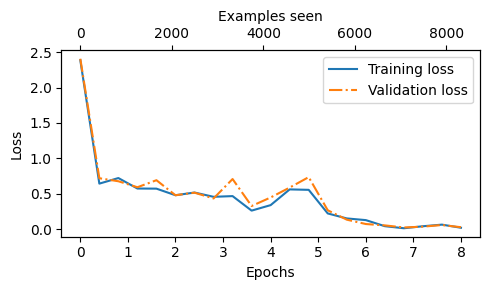

In [49]:
import matplotlib.pyplot as plt
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
  fig, ax1 = plt.subplots(figsize=(5, 3))
  ax1.plot(epochs_seen, train_values, label=f"Training {label}")
  ax1.plot(
  epochs_seen, val_values, linestyle="-.",
  label=f"Validation {label}"
  )
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel(label.capitalize())

  ax1.legend()

  ax2 = ax1.twiny()
  ax2.plot(examples_seen, train_values, alpha=0)
  ax2.set_xlabel("Examples seen")
  fig.tight_layout()
  plt.savefig(f"{label}-plot.pdf")
  plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)